In [ ]:
!pip install -q tensorflow==2.1

In [ ]:
import time
import random
import numpy as np

import gym

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

import matplotlib.pyplot as plt
%matplotlib inline
print(tf.__version__)

2.1.0


In [ ]:
# Проверяем что у нас работает GPU
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
#GPU count and name
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-1e1fddac-f763-f1c4-0b15-75da0319b45a)


## Load GYM environment

In [ ]:
env = gym.make('CartPole-v0')

STATE_LIMITS = env.observation_space
NUM_ACTIONS = env.action_space.n

print('Actions: {}'.format(NUM_ACTIONS))
print('States limits:')
for i in range(STATE_LIMITS.shape[0]):
    print('[{}, {}]'.format(STATE_LIMITS.low[i], STATE_LIMITS.high[i]))

Actions: 2
States limits:
[-4.800000190734863, 4.800000190734863]
[-3.4028234663852886e+38, 3.4028234663852886e+38]
[-0.41887903213500977, 0.41887903213500977]
[-3.4028234663852886e+38, 3.4028234663852886e+38]


## Settings

In [ ]:
LR = 0.001
gamma = 0.95

NUM_EPISODES = 2000
MAX_STEPS = 200
REWARD_AVERAGE_WINDOW = 20

## DQN Model

In [ ]:
model = M.Sequential([
    L.Dense(24, activation='relu'),
    L.Dense(24, activation='relu'),
    L.Dense(NUM_ACTIONS, activation=None, use_bias=False),
])

def evalQ(s):
    return model(s[None, ...].astype(np.float32)).numpy()[0]

## Prepare model for training

In [ ]:
#def loss(q1, q2):
#    return tf.reduce_sum(tf.square(q1 - q2))

optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
model.compile(loss='mse', optimizer=optimizer)

pathLenList = []
totalRewardList = []
totalRewardAverageList = []

## DQN training

In [ ]:
for i in range(NUM_EPISODES):
    
    eps = 1./((i/50) + 10)
    
    s = env.reset()
    
    totalReward = 0
    step = 0
    
    while step < MAX_STEPS:
        step += 1

        Q_s = evalQ(s)
        
        if np.random.rand() < eps:
            a = env.action_space.sample()
        else:
            a = np.argmax(Q_s)

        s1, r, done, _ = env.step(a)

        Q_s1 = evalQ(s1)
        
        Q_target = Q_s
        if done:
            Q_target[a] = r
        else:
            Q_target[a] = r + gamma * np.max(Q_s1)
 
        model.train_on_batch(s[None, ...].astype(np.float32), Q_target[None, ...])

        totalReward += r
        s = s1
        
        if done:
            break
            
    pathLenList.append(step)
    totalRewardList.append(totalReward)

    if i % REWARD_AVERAGE_WINDOW == 0 and i >= REWARD_AVERAGE_WINDOW:
        totalRewardAverage = np.mean(totalRewardList[-REWARD_AVERAGE_WINDOW:])
        totalRewardAverageList.append(totalRewardAverage)
        if i % 100 == 0:
            print('Episode {}: average total reward = {}'.format(i, totalRewardAverage))

Episode 100: average total reward = 9.9
Episode 200: average total reward = 22.65
Episode 300: average total reward = 37.0
Episode 400: average total reward = 37.9
Episode 500: average total reward = 80.6
Episode 600: average total reward = 66.4
Episode 700: average total reward = 199.0
Episode 800: average total reward = 140.45
Episode 900: average total reward = 89.8
Episode 1000: average total reward = 104.8
Episode 1100: average total reward = 89.85
Episode 1200: average total reward = 100.15
Episode 1300: average total reward = 147.55
Episode 1400: average total reward = 123.25
Episode 1500: average total reward = 126.7
Episode 1600: average total reward = 135.15
Episode 1700: average total reward = 134.0
Episode 1800: average total reward = 169.6
Episode 1900: average total reward = 172.2


## Plot trajectory length over time

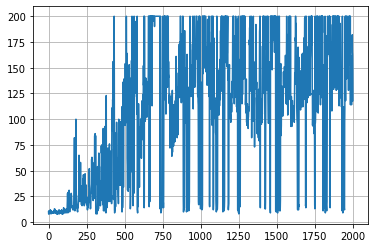

In [ ]:
plt.plot(pathLenList)
plt.grid()

## Plot average total reward over time

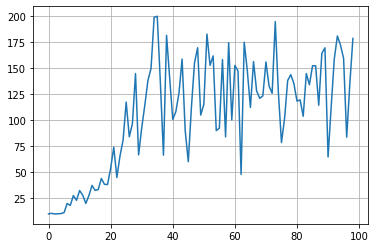

In [ ]:
plt.plot(totalRewardAverageList)
plt.grid()

In [ ]:
RECORD_VIDEO = True

if RECORD_VIDEO:
  
    !pip install pyvirtualdisplay > /dev/null 2>&1
    !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(1400, 900))
    display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


## Run simulation

In [ ]:
USE_Q = True

if RECORD_VIDEO:
    from gym.wrappers import Monitor
    env_sim = Monitor(env, './video', force=True)
else:
    env_sim = env
    
s = env_sim.reset()
totalReward = 0

for _ in range(1000):
    env_sim.render()
    if USE_Q:
        a = np.argmax(evalQ(s))
    else:
        a = env_sim.action_space.sample()    
    s, r, done, _ = env_sim.step(a)
    totalReward += r
    if done:
        break
       
    if not RECORD_VIDEO:
        time.sleep(1./30)
        
env_sim.close()

print('Total reward = {}'.format(totalReward))

Total reward = 110.0


## Show the video

In [ ]:
def show_video():
    import glob
    import io
    import base64
    from IPython.display import HTML
    from IPython import display as ipythondisplay

    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
            loop controls style="height: 400px;">
            <source src="data:video/mp4;base64,{0}" type="video/mp4" />
            </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    
show_video()

In [ ]:
# как видим, задача увы не решена - в итоге уходим за допустимые границы игры. 
# А нам нужно, чтоб она смогла стоять не ограниченное время (как это было на видео)
# в этом и есть наша задача в ДЗ